In [1]:
import sys
sys.path.append('../../_common/database_communicator/')

In [2]:
from db_connector import DBConnector
import pandas as pd

In [3]:
connector = DBConnector()
engine = connector.create_sql_engine()

In [4]:
df = pd.read_sql_query("SELECT * FROM data_staging", con=engine)

In [5]:
df['price'] = df['price'].str.replace('zł', '').str \
    .replace(' ', '') \
    .replace(',', '.', regex=True) \
    .replace('Zapytajocenę', None, regex=True) \
    .astype(float)

In [6]:
df['size']= df['size'].str.replace(',', '.').astype(float)

In [7]:
df.head()

,url,price,status,size,property_type,rooms,floor,year_built,property_condition,location,desc,image_url
0,https://www.otodom.pl/pl/oferta/nowoczesne-dwu...,630000.0,wtórny,68.00,brak informacji,2,1/6,brak informacji,do zamieszkania,"ul. Chartowo, Chartowo, Nowe Miasto, Poznań, w...",Z przyjemnością przedstawiam ofertę sprzedaży ...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...
1,https://www.otodom.pl/pl/oferta/nowe-3-pokoje-...,552520.0,pierwotny,51.00,blok,3,1,2023,do wykończenia,"Starołęka Mała, Nowe Miasto, Poznań, wielkopol...",Możliwość kontaktu telefonicznego w godzinach ...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...
2,https://www.olx.pl/d/oferta/mieszkanie-3-pokoj...,649000.0,wtórny,59.00,blok,3,1,None,None,"Poznań, Naramowice\nWielkopolskie",Zamieszkaj w dzielnicy Poznania blisko natury!...,https://ireland.apollo.olxcdn.com:443/v1/files...
3,https://www.otodom.pl/pl/oferta/wynajety-apart...,679000.0,pierwotny,41.92,apartamentowiec,2,5/5,2023,zapytaj,"Łacina, Nowe Miasto, Poznań, wielkopolskie",Oferta bezpośrednio od właściciela – BRAK prow...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...
4,https://www.otodom.pl/pl/oferta/atrakcyjne-mie...,679000.0,wtórny,43.65,kamienica,2,3/4,1900,do zamieszkania,"ul. Tylne Chwaliszewo, Chwaliszewo, Stare Mias...",* Stylowo urządzone * CHWALISZEWO *\n\nPrzedst...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...


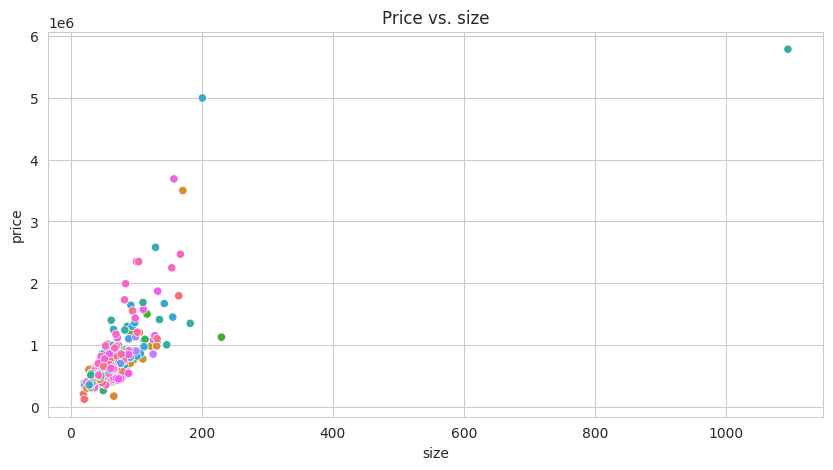

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.scatterplot(x='size', y='price', data=df, hue='location', legend=False)
plt.title('Price vs. size')
plt.show()

In [9]:
df[df['size'] > 1000]

,url,price,status,size,property_type,rooms,floor,year_built,property_condition,location,desc,image_url
219,https://www.otodom.pl/pl/oferta/cala-kamienica...,5790000.0,wtórny,1094.0,kamienica,None,parter/5,1939,do zamieszkania,"ul. Kanałowa, Łazarz, Grunwald, Poznań, wielko...",Oferujemy do sprzedaży atrakcyjną kamienicę po...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...


In [10]:
df = df[df['price'].notna()]

In [11]:
from sklearn.ensemble import IsolationForest
import numpy as np

clf = IsolationForest(max_samples=5, contamination=0.005, random_state=42).fit(df[['size', 'price']])

clf.predict(df[['size', 'price']])
df['outlier'] = clf.predict(df[['size', 'price']])

print(len(df))
print(len(df[df['outlier'] == -1]))

640
0


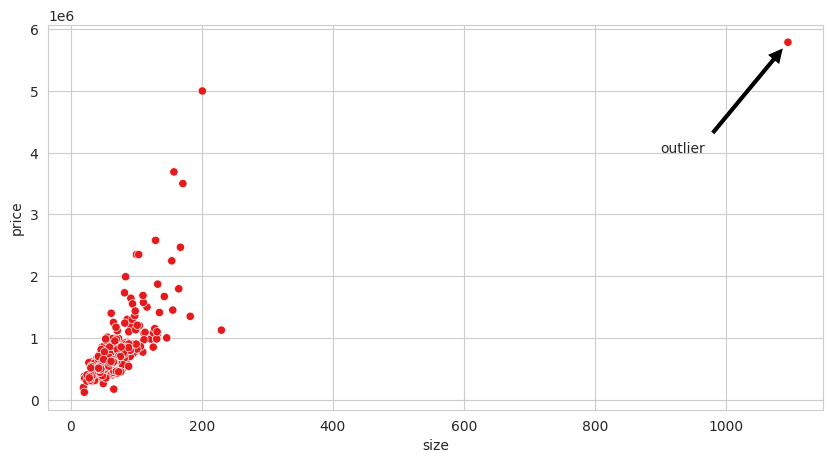

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.scatterplot(x='size', y='price', data=df, hue='outlier', legend=False, palette='Set1')
plt.annotate('outlier', xy=(1094.0, 5790000.0), xytext=(900, 4000000), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [13]:
df['status'].fillna('brak informacji', inplace=True)
df['property_type'].fillna('brak informacji', inplace=True)
df['rooms'].fillna(1, inplace=True)
df['year_built'].fillna('brak informacji', inplace=True)
df['floor'].fillna('brak informacji', inplace=True)
df['property_condition'].fillna('brak informacji', inplace=True)

In [14]:
import pandas as pd
import re

loc_list = ['Grunwald', 'Górczyn', 'Ławica', 'Łazarz', 'Junikowo', 'Jeżyce', 
            'Podolany', 'Sołacz', 'Wilda', 'Dębiec', 'Nowe Miasto', 'Łacina', 
            'Rataje', 'Starołęka Mała', 'Stare Miasto', 'Naramowice', 
            'Piątkowo', 'Winogrady', 'Chartowo']

# Function to find and return matching location from loc_list
def find_location(x):
    for loc in loc_list:
        if bool(re.search(loc, x)):
            return loc
    return 'Poznań'

# Apply the function on 'location' column
df['location'] = df['location'].apply(find_location)

In [15]:
df['floor'] = df['floor'].apply(lambda x: x.split('/')[0] if type(x) == str else x)

In [16]:
import pandas as pd

def extract_numbers(s):
    return ''.join(filter(str.isdigit, s)) if any(map(str.isdigit, s)) else s


df['floor'] = df['floor'].str.replace('parter', '0').str.replace('poddasze', '10').apply(extract_numbers)

In [17]:
df['floor'].unique()

array(['1', '5', '3', '2', '0', '4', '7', '10', 'zapytaj', '6',
       'suterena', '8', 'brak informacji', '9'], dtype=object)

In [18]:
numerical_col = ['size', 'rooms']
categorical_col = ['status', 'property_type', 'floor', 'year_built', 'property_condition', 'location']

for col in numerical_col:
    df[col] = df[col].astype(float)
    
for col in categorical_col:
    df[col] = df[col].astype('category')

In [19]:
df.head()

,url,price,status,size,property_type,rooms,floor,year_built,property_condition,location,desc,image_url,outlier
0,https://www.otodom.pl/pl/oferta/nowoczesne-dwu...,630000.0,wtórny,68.00,brak informacji,2.0,1,brak informacji,do zamieszkania,Nowe Miasto,Z przyjemnością przedstawiam ofertę sprzedaży ...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,1
1,https://www.otodom.pl/pl/oferta/nowe-3-pokoje-...,552520.0,pierwotny,51.00,blok,3.0,1,2023,do wykończenia,Nowe Miasto,Możliwość kontaktu telefonicznego w godzinach ...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,1
2,https://www.olx.pl/d/oferta/mieszkanie-3-pokoj...,649000.0,wtórny,59.00,blok,3.0,1,brak informacji,brak informacji,Naramowice,Zamieszkaj w dzielnicy Poznania blisko natury!...,https://ireland.apollo.olxcdn.com:443/v1/files...,1
3,https://www.otodom.pl/pl/oferta/wynajety-apart...,679000.0,pierwotny,41.92,apartamentowiec,2.0,5,2023,zapytaj,Nowe Miasto,Oferta bezpośrednio od właściciela – BRAK prow...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,1
4,https://www.otodom.pl/pl/oferta/atrakcyjne-mie...,679000.0,wtórny,43.65,kamienica,2.0,3,1900,do zamieszkania,Stare Miasto,* Stylowo urządzone * CHWALISZEWO *\n\nPrzedst...,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,1


In [75]:
X = df[['status', 'size', 'property_type', 'rooms', 'floor', 'year_built', 'property_condition', 'location']]
y = df['price'].astype(float)

In [21]:
X.head()

,status,size,property_type,rooms,floor,year_built,property_condition,location
0,wtórny,68.00,brak informacji,2.0,1,brak informacji,do zamieszkania,Nowe Miasto
1,pierwotny,51.00,blok,3.0,1,2023,do wykończenia,Nowe Miasto
2,wtórny,59.00,blok,3.0,1,brak informacji,brak informacji,Naramowice
3,pierwotny,41.92,apartamentowiec,2.0,5,2023,zapytaj,Nowe Miasto
4,wtórny,43.65,kamienica,2.0,3,1900,do zamieszkania,Stare Miasto


In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)


In [23]:
# X_val.to_csv('X_val.tsv', index=False, sep = '\t')
# y_val.to_csv('y_val.tsv', index=False, sep = '\t')
# X_test.to_csv('X_test.tsv', index=False, sep = '\t')
# y_test.to_csv('y_test.tsv', index=False, sep = '\t')
# X_train.to_csv('X_train.tsv', index=False, sep = '\t')
# y_train.to_csv('y_train.tsv', index=False, sep = '\t')

# Model

In [72]:
import numpy as np

from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [73]:
regressor = XGBRegressor(enable_categorical=True)

In [74]:
## Hyper Parameter Optimization


n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    # 'max_depth':max_depth,
    'learning_rate':learning_rate,
    # 'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [77]:
# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=4, n_iter=100,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 3, 
            return_train_score = True,
            random_state=42)

In [78]:
random_cv.fit(X_train,y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 2/4] END base_score=0.75, booster=gblinear, learning_rate=0.1, n_estimators=100;, score=(train=-152104.804, test=-121763.288) total time=   0.1s
[CV 4/4] END base_score=0.75, booster=gblinear, learning_rate=0.1, n_estimators=100;, score=(train=-140109.479, test=-138085.304) total time=   0.1s
[CV 3/4] END base_score=0.75, booster=gblinear, learning_rate=0.1, n_estimators=100;, score=(train=-131471.922, test=-179643.174) total time=   0.1s
[CV 1/4] END base_score=0.75, booster=gblinear, learning_rate=0.1, n_estimators=100;, score=(train=-134135.666, test=-142919.356) total time=   0.1s
[CV 1/4] END base_score=0.75, booster=gblinear, learning_rate=0.1, n_estimators=1100;, score=(train=-138024.745, test=-144347.253) total time=   0.2s
[CV 4/4] END base_score=0.75, booster=gblinear, learning_rate=0.1, n_estimators=1100;, score=(train=-145892.109, test=-143228.978) total time=   0.2s
[CV 3/4] END base_score=0.75, booster=gbl

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=N...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=100, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=3)

In [79]:
model = random_cv.best_estimator_

In [80]:
from sklearn.metrics import mean_absolute_error
preds = model.predict(X_test)

# Evaluate the model
score = mean_absolute_error(y_test, preds)
print('MAE:', score)

MAE: 103995.48325195312
